<a href="https://colab.research.google.com/github/assayonare/CNN-for-assessing-the-state-of-capillaries/blob/main/capillaroscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os
import csv

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import load_model

def merge_overlapping_boxes(boxes, overlapThresh=0.3):
    """
    –û–±—ä–µ–¥–∏–Ω—è–µ—Ç –ø–µ—Ä–µ–∫—Ä—ã–≤–∞—é—â–∏–µ—Å—è –±–æ–∫—Å—ã.
    –ö–∞–∂–¥—ã–π –±–æ–∫—Å –∑–∞–¥–∞–µ—Ç—Å—è –≤ —Ñ–æ—Ä–º–∞—Ç–µ (x, y, w, h).
    """
    if len(boxes) == 0:
        return []

    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –±–æ–∫—Å—ã –≤ —Ñ–æ—Ä–º–∞—Ç (x1, y1, x2, y2)
    boxes_arr = np.array([[x, y, x+w, y+h] for (x, y, w, h) in boxes])
    merged = True
    while merged:
        merged = False
        new_boxes = []
        used = np.zeros(len(boxes_arr), dtype=bool)

        for i in range(len(boxes_arr)):
            if used[i]:
                continue
            # –¢–µ–∫—É—â–∏–π –±–æ–∫—Å
            current_box = boxes_arr[i].copy()
            for j in range(i+1, len(boxes_arr)):
                if used[j]:
                    continue
                box = boxes_arr[j]
                # –í—ã—á–∏—Å–ª—è–µ–º –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏–µ
                xx1 = max(current_box[0], box[0])
                yy1 = max(current_box[1], box[1])
                xx2 = min(current_box[2], box[2])
                yy2 = min(current_box[3], box[3])
                w = max(0, xx2 - xx1)
                h = max(0, yy2 - yy1)
                inter = w * h
                area_current = (current_box[2]-current_box[0]) * (current_box[3]-current_box[1])
                area_box = (box[2]-box[0]) * (box[3]-box[1])
                iou = inter / float(area_current + area_box - inter)
                if iou > overlapThresh:
                    # –û–±—ä–µ–¥–∏–Ω—è–µ–º –±–æ–∫—Å—ã
                    current_box[0] = min(current_box[0], box[0])
                    current_box[1] = min(current_box[1], box[1])
                    current_box[2] = max(current_box[2], box[2])
                    current_box[3] = max(current_box[3], box[3])
                    used[j] = True
                    merged = True
            new_boxes.append(current_box)
            used[i] = True
        boxes_arr = np.array(new_boxes)
    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º –≤ —Ñ–æ—Ä–º–∞—Ç–µ (x, y, w, h)
    return [(int(x1), int(y1), int(x2-x1), int(y2-y1)) for x1, y1, x2, y2 in boxes_arr]


# –ó–∞–¥–∞—ë–º –≤—Ö–æ–¥–Ω–æ–π —Ä–∞–∑–º–µ—Ä, –∫–æ—Ç–æ—Ä—ã–π –æ–∂–∏–¥–∞–µ—Ç –º–æ–¥–µ–ª—å (–Ω–∞–ø—Ä–∏–º–µ—Ä, 64x64)
input_size = (64, 64)

# 2. –ó–∞–≥—Ä—É–∂–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∫–∞–ø–∏–ª–ª—è—Ä–æ–≤ –≤ –æ—Ç—Ç–µ–Ω–∫–∞—Ö —Å–µ—Ä–æ–≥–æ
image = cv2.imread("/content/drive/MyDrive/inp/image_capillar (13).png", cv2.IMREAD_GRAYSCALE)
if image is None:
    raise Exception("–ù–µ —É–¥–∞–ª–æ—Å—å –∑–∞–≥—Ä—É–∑–∏—Ç—å –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ!")

# 3. –£–ª—É—á—à–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ: —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏—è —à—É–º–∞, –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –≥—Ä–∞–Ω–∏—Ü –∏ –ø–æ–∏—Å–∫ –∫–æ–Ω—Ç—É—Ä–æ–≤
blurred = cv2.GaussianBlur(image, (3, 3), 0)
edges = cv2.Canny(blurred, 50, 150)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 20]

# 4. –û–ø—Ä–µ–¥–µ–ª—è–µ–º bounding boxes (–ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω—ã–µ —Ä–∞–º–∫–∏) —Å –æ—Ç—Å—Ç—É–ø–æ–º
padding = 30  # —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —Ä–∞–º–∫–∏
boxes = []
for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    x_new = max(0, x - padding)
    y_new = max(0, y - padding)
    w_new = min(image.shape[1] - x_new, w + 2 * padding)
    h_new = min(image.shape[0] - y_new, h + 2 * padding)
    boxes.append((x_new, y_new, w_new, h_new))

# 5. –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è bounding boxes –ø–æ —Ü–µ–Ω—Ç—Ä–∞–º (DBSCAN)
box_centers = [(x + w // 2, y + h // 2) for x, y, w, h in boxes]
X = np.array(box_centers)
dbscan = DBSCAN(eps=35, min_samples=1).fit(X)
clustered_boxes = {}
for label, box in zip(dbscan.labels_, boxes):
    if label not in clustered_boxes:
        clustered_boxes[label] = []
    clustered_boxes[label].append(box)

# 6. –°–æ–∑–¥–∞–µ–º –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã–µ bounding boxes –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–∞
final_boxes = []
for cluster in clustered_boxes.values():
    x_min = min(x for x, y, w, h in cluster)
    y_min = min(y for x, y, w, h in cluster)
    x_max = max(x + w for x, y, w, h in cluster)
    y_max = max(y + h for x, y, w, h in cluster)
    final_boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))

# 7. –ü—Ä–∏–º–µ–Ω—è–µ–º –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–µ –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ, —á—Ç–æ–±—ã –±–æ–∫—Å—ã –Ω–µ –ø–µ—Ä–µ–∫—Ä—ã–≤–∞–ª–∏—Å—å
final_boxes = merge_overlapping_boxes(final_boxes, overlapThresh=0.3)

# 8. –ì–æ—Ç–æ–≤–∏–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ (–∫–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º –≤ BGR, —á—Ç–æ–±—ã –º–æ–∂–Ω–æ –±—ã–ª–æ –Ω–∞–ª–æ–∂–∏—Ç—å —Ü–≤–µ—Ç–Ω–æ–µ –≤—ã–¥–µ–ª–µ–Ω–∏–µ)
image_with_overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# 9. –î–ª—è –∫–∞–∂–¥–æ–≥–æ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω–æ–≥–æ —Å–µ–≥–º–µ–Ω—Ç–∞:
#    - –ò–∑–≤–ª–µ–∫–∞–µ–º ROI, –º–∞—Å—à—Ç–∞–±–∏—Ä—É–µ–º –¥–æ input_size, –Ω–æ—Ä–º–∞–ª–∏–∑—É–µ–º –∏ –ø–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏.
#    - –ï—Å–ª–∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –∫–ª–∞—Å—Å 0 (–¥–µ—Ñ–µ–∫—Ç–Ω—ã–π), –≤—ã–¥–µ–ª—è–µ–º –æ–±–ª–∞—Å—Ç—å –∫—Ä–∞—Å–Ω—ã–º –ø–æ–ª—É–ø—Ä–æ–∑—Ä–∞—á–Ω—ã–º –Ω–∞–ª–æ–∂–µ–Ω–∏–µ–º.
for (x, y, w, h) in final_boxes:
    roi = image[y:y+h, x:x+w]
    # –ï—Å–ª–∏ –º–æ–¥–µ–ª—å –æ–∂–∏–¥–∞–µ—Ç 3 –∫–∞–Ω–∞–ª–∞, –ø—Ä–µ–æ–±—Ä–∞–∑—É–µ–º ROI –≤ —Ü–≤–µ—Ç–Ω–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
    roi_color = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)
    roi_resized = cv2.resize(roi_color, input_size)
    roi_normalized = roi_resized.astype('float32') / 255.0
    roi_input = np.expand_dims(roi_normalized, axis=0)

    # –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
    prediction = model.predict(roi_input)

    # –ï—Å–ª–∏ –∑–Ω–∞—á–µ–Ω–∏–µ –º–µ–Ω—å—à–µ 0.5, —Å—á–∏—Ç–∞–µ–º —Å–µ–≥–º–µ–Ω—Ç –¥–µ—Ñ–µ–∫—Ç–Ω—ã–º (–∫–ª–∞—Å—Å 0)
    if prediction[0][0] < 0.5:
        overlay = image_with_overlay.copy()
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 0, 255), -1)  # –∑–∞–ª–∏–≤–∫–∞ –∫—Ä–∞—Å–Ω—ã–º
        alpha = 0.4  # –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –ø—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç–∏
        image_with_overlay = cv2.addWeighted(overlay, alpha, image_with_overlay, 1 - alpha, 0)

# 10. –û—Ç–æ–±—Ä–∞–∂–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç —á–µ—Ä–µ–∑ matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_with_overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("–°–µ–≥–º–µ–Ω—Ç—ã –∫–ª–∞—Å—Å–∞ 0 (–±–µ–∑ –ø–µ—Ä–µ–∫—Ä—ã–≤–∞—é—â–∏—Ö—Å—è –±–æ–∫—Å–æ–≤)")
plt.show()

KeyboardInterrupt: 

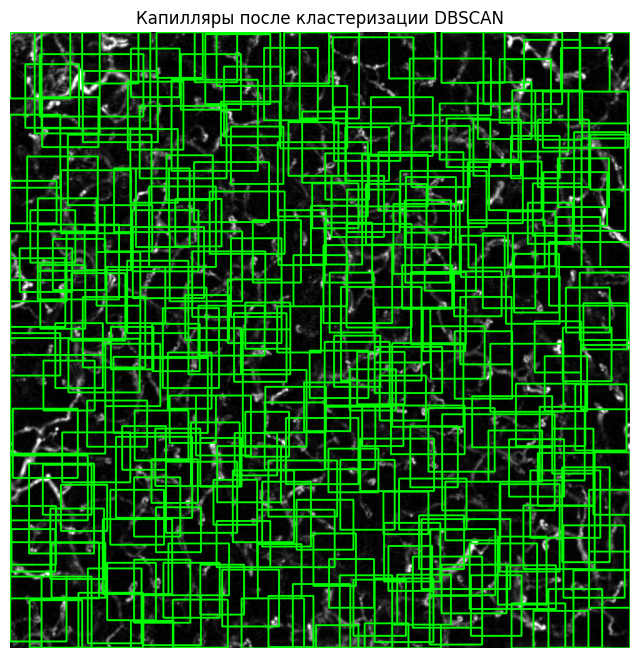

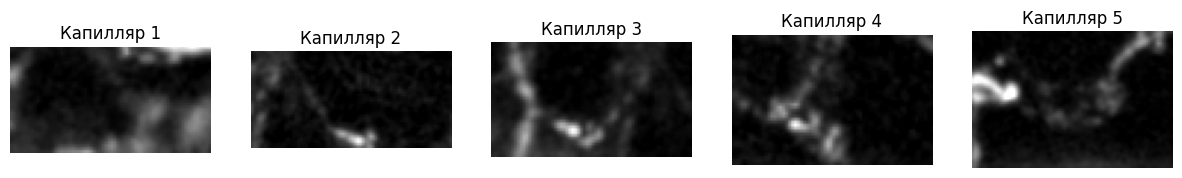

In [ ]:
image = cv2.imread("/content/drive/MyDrive/inp/image_capillar (19).png", cv2.IMREAD_GRAYSCALE)

# 2. –£–ª—É—á—à–µ–Ω–∏–µ –∫–æ–Ω—Ç—Ä–∞—Å—Ç–∞ (CLAHE)
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# image = clahe.apply(image)

# 3. –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è —à—É–º–∞
blurred = cv2.GaussianBlur(image, (3,3), 0)

# 4. –û–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –≥—Ä–∞–Ω–∏—Ü (Canny)
edges = cv2.Canny(blurred, 50, 150)

# 5. –ü–æ–∏—Å–∫ –∫–æ–Ω—Ç—É—Ä–æ–≤
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 6. –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è –∫–æ–Ω—Ç—É—Ä–æ–≤ (—É–¥–∞–ª—è–µ–º —Å–ª–∏—à–∫–æ–º –º–∞–ª–µ–Ω—å–∫–∏–µ –æ–±—ä–µ–∫—Ç—ã)
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 20]

# 7. –û–ø—Ä–µ–¥–µ–ª—è–µ–º bounding boxes (–ø—Ä—è–º–æ—É–≥–æ–ª—å–Ω—ã–µ —Ä–∞–º–∫–∏)
padding = 30  # –£–≤–µ–ª–∏—á–µ–Ω–∏–µ —Ä–∞–º–∫–∏
boxes = []

for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    x_new = max(0, x - padding)
    y_new = max(0, y - padding)
    w_new = min(image.shape[1] - x_new, w + 2 * padding)
    h_new = min(image.shape[0] - y_new, h + 2 * padding)
    boxes.append((x_new, y_new, w_new, h_new))

# 8. –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º bounding boxes –≤ —Ñ–æ—Ä–º–∞—Ç (x, y) —Ü–µ–Ω—Ç—Ä–∞ + —Ä–∞–∑–º–µ—Ä—ã
box_centers = [(x + w // 2, y + h // 2) for x, y, w, h in boxes]
box_sizes = [(w, h) for _, _, w, h in boxes]

# 9. –ü—Ä–∏–º–µ–Ω—è–µ–º DBSCAN –¥–ª—è –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏ –±–ª–∏–∑–∫–∏—Ö –∫–∞–ø–∏–ª–ª—è—Ä–æ–≤
X = np.array(boxes)  # –ú–∞—Å—Å–∏–≤ –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç —Ü–µ–Ω—Ç—Ä–æ–≤ —Ä–∞–º–æ–∫
dbscan = DBSCAN(eps=35, min_samples=1).fit(X)  # eps ‚Äî —Ä–∞–¥–∏—É—Å –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏—è

# 10. –ì—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ —Ä–∞–º–æ–∫ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º
clustered_boxes = {}
for label, ((x, y), (w, h)) in zip(dbscan.labels_, zip(box_centers, box_sizes)):
    if label not in clustered_boxes:
        clustered_boxes[label] = []
    clustered_boxes[label].append((x, y, w, h))

# 11. –°–æ–∑–¥–∞–µ–º –æ–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã–µ bounding boxes –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Ç–µ—Ä–∞
final_boxes = []
for cluster in clustered_boxes.values():
    x_min = min(x - w // 2 for x, y, w, h in cluster)
    y_min = min(y - h // 2 for x, y, w, h in cluster)
    x_max = max(x + w // 2 for x, y, w, h in cluster)
    y_max = max(y + h // 2 for x, y, w, h in cluster)
    final_boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))

# 12. –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# 13. –í—ã—Ä–µ–∑–∞–µ–º –∏ —Å–æ—Ö—Ä–∞–Ω—è–µ–º —Å–µ–≥–º–µ–Ω—Ç—ã
segments = []
for (x, y, w, h) in final_boxes:
    segment = image[y:y+h, x:x+w]
    segments.append(segment)
    cv2.rectangle(image_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)

# 14. –í—ã–≤–æ–¥ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è —Å –∏—Ç–æ–≥–æ–≤—ã–º–∏ —Ä–∞–º–∫–∞–º–∏
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.title("–ö–∞–ø–∏–ª–ª—è—Ä—ã –ø–æ—Å–ª–µ –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏ DBSCAN")
plt.axis("off")
plt.show()

# 15. –í—ã–≤–æ–¥ –∫–∞–∂–¥–æ–≥–æ —Å–µ–≥–º–µ–Ω—Ç–∞ –æ—Ç–¥–µ–ª—å–Ω–æ
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(segments[i], cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"–ö–∞–ø–∏–ª–ª—è—Ä {i+1}")

plt.show()

In [ ]:
def save_segment(segment, segment_id, output_dir="/content/drive/MyDrive/inp/segments19"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    segment_filename = f"{output_dir}/segment_{4122+segment_id}.png"
    cv2.imwrite(segment_filename, segment)  # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è

segment_id = 1  # –ò–¥–µ–Ω—Ç–∏—Ñ–∏–∫–∞—Ç–æ—Ä —Å–µ–≥–º–µ–Ω—Ç–∞ (–º–æ–∂–Ω–æ —É–≤–µ–ª–∏—á–∏—Ç—å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Å–µ–≥–º–µ–Ω—Ç–∞)
for segment in segments:
    segment = cv2.resize(segment, (64, 64))
    save_segment(segment, segment_id)
    segment_id += 1

In [ ]:
def write_to_csv(segment_id, label, csv_filename="/content/drive/MyDrive/inp/labels19.csv"):
    with open(csv_filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([f"segment_{4122+segment_id}.png", label])

# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
for segment_id in range(1, segment_id+1):
    label = "1"  # –∏–ª–∏ "unhealthy"
    write_to_csv(segment_id, label)


In [ ]:
import pandas as pd

# –ó–∞–≥—Ä—É–∑–∫–∞ CSV-—Ñ–∞–π–ª–∞
df = pd.read_csv('/content/drive/MyDrive/capillaroscopy/csv/labels.csv')

# –ü–æ–¥—Å—á—ë—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —ç–ª–µ–º–µ–Ω—Ç–æ–≤ –≤ –∫–∞–∂–¥–æ–º –∫–ª–∞—Å—Å–µ
class_counts = df['class'].value_counts()

# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
print("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ª–µ–º–µ–Ω—Ç–æ–≤ –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞:")
print(class_counts)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ª–µ–º–µ–Ω—Ç–æ–≤ –∫–∞–∂–¥–æ–≥–æ –∫–ª–∞—Å—Å–∞:
class
1    3354
2     403
0     161
Name: count, dtype: int64


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/capillaroscopy/csv/labels.csv")
df["filepath"] = df["filename"].apply(lambda x: os.path.join("/content/drive/MyDrive/capillaroscopy/data/train", x))
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class"], random_state=42)


X_train = np.array(train_df["filepath"])
y_train = np.array(train_df["class"])

# Oversampling —Ä–µ–¥–∫–∏—Ö –∫–ª–∞—Å—Å–æ–≤
ros = RandomOverSampler(sampling_strategy="auto")  # –ê–≤—Ç–æ-—É—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(-1, 1), y_train)

# –û–±–Ω–æ–≤–ª—è–µ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
train_df_resampled = pd.DataFrame({"filepath": X_resampled.flatten(), "class": y_resampled})

print(f"Train: {len(train_df_resampled)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 7041, Validation: 588, Test: 588


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)  # –ë–µ–∑ –∞—É–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
train_df_resampled["class"] = train_df_resampled["class"].astype(str)
val_df["class"] = val_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)
# –ì–µ–Ω–µ—Ä–∞—Ç–æ—Ä—ã –¥–∞–Ω–Ω—ã—Ö
train_generator = train_datagen.flow_from_dataframe(train_df_resampled, x_col="filepath", y_col="class", target_size=(64, 64),
                                                    batch_size=32, class_mode="sparse")
val_generator = val_test_datagen.flow_from_dataframe(val_df, x_col="filepath", y_col="class", target_size=(64, 64),
                                                     batch_size=32, class_mode="sparse")
test_generator = val_test_datagen.flow_from_dataframe(test_df, x_col="filepath", y_col="class", target_size=(64, 64),
                                                      batch_size=32, class_mode="sparse", shuffle=False)

Found 7039 validated image filenames belonging to 3 classes.
Found 588 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 587 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º EfficientNetB0 –±–µ–∑ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ —Å–ª–æ—è
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
# base_model.trainable = False  # –ó–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –ø—Ä–µ–¥–æ–±—É—á–µ–Ω–Ω—ã–µ –≤–µ—Å–∞
for layer in base_model.layers[:-10]:  # –ú–æ–∂–Ω–æ –æ—Å—Ç–∞–≤–∏—Ç—å –ø–æ—Å–ª–µ–¥–Ω–∏–µ 10 –æ–±—É—á–∞–µ–º—ã–º–∏
    layer.trainable = False
# –î–æ–±–∞–≤–ª—è–µ–º —Å–≤–æ–∏ —Å–ª–æ–∏
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dense(128, activation="relu")(x)
# x = Dense(3, activation="softmax")(x)  # 3 –∫–ª–∞—Å—Å–∞

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # –£–º–µ–Ω—å—à–∞–µ—Ç –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)  # 3 –∫–ª–∞—Å—Å–∞


# –§–∏–Ω–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#class_weights = compute_class_weight("balanced", classes=np.unique(train_df["class"]), y=train_df["class"])

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ —Å–ª–æ–≤–∞—Ä—å
#class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
history = model.fit(train_generator, validation_data=val_generator, epochs=20, steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator))
# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ —Å —É—á–µ—Ç–æ–º –≤–µ—Å–æ–≤ –∫–ª–∞—Å—Å–æ–≤
#history = model.fit(train_generator, validation_data=val_generator, epochs=20,
#                    steps_per_epoch=len(train_generator), validation_steps=len(val_generator),
#                   class_weight=class_weight_dict)

16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 68s 301ms/step - accuracy: 0.4545 - loss: 5.3607 - val_accuracy: 0.1431 - val_loss: 0.6932
Epoch 2/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 150ms/step - accuracy: 0.4896 - loss: 4.3340 - val_accuracy: 0.8569 - val_loss: 0.6932
Epoch 3/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 145ms/step - accuracy: 0.5066 - loss: 4.2811 - val_accuracy: 0.8569 - val_loss: 0.6932
Epoch 4/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 153ms/step - accuracy: 0.5022 - loss: 4.0022 - val_accuracy: 0.8569 - val_loss: 0.6932
Epoch 5/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 148ms/step - accuracy: 0.4957 - loss: 4.1130 - val_accuracy: 0.8569 - val_loss: 0.6932
Epoch 6/20
147/147 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 42s 154ms/step - accuracy: 0.5019 - loss: 4.0072 - val_accuracy: 

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

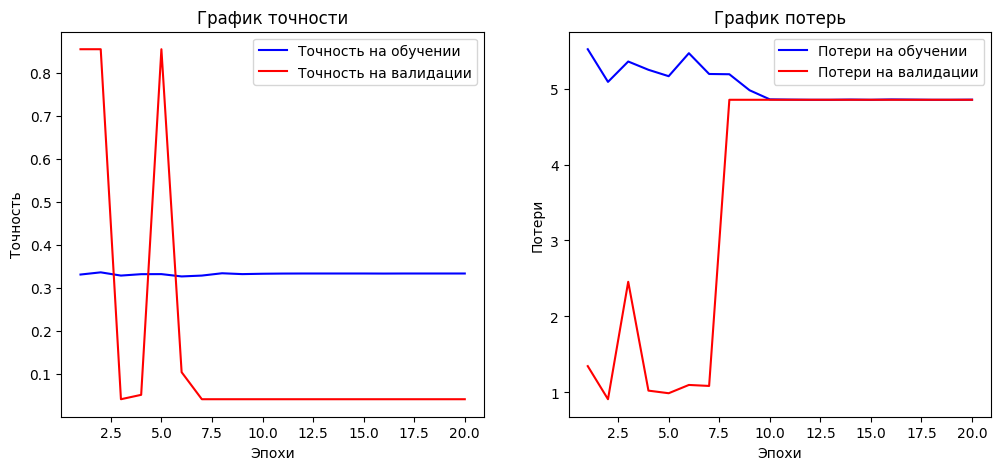

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# –ì—Ä–∞—Ñ–∏–∫ —Ç–æ—á–Ω–æ—Å—Ç–∏
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –æ–±—É—á–µ–Ω–∏–∏")
plt.plot(epochs, val_acc, "r-", label="–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏")
plt.xlabel("–≠–ø–æ—Ö–∏")
plt.ylabel("–¢–æ—á–Ω–æ—Å—Ç—å")
plt.legend()
plt.title("–ì—Ä–∞—Ñ–∏–∫ —Ç–æ—á–Ω–æ—Å—Ç–∏")

# –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –æ–±—É—á–µ–Ω–∏–∏")
plt.plot(epochs, val_loss, "r-", label="–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏")
plt.xlabel("–≠–ø–æ—Ö–∏")
plt.ylabel("–ü–æ—Ç–µ—Ä–∏")
plt.legend()
plt.title("–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å")

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ: {test_acc * 100:.2f}%")

19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 194s 11s/step - accuracy: 0.0322 - loss: 4.8520
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ: 4.09%


In [ ]:
model.save("/content/drive/MyDrive/capillaroscopy/capillaries_classifier1.keras")

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/capillaroscopy/csv/labels.csv")
test_class_0_df = test_df[test_df["class"] == 1].copy()

# –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–ª–Ω—ã–π –ø—É—Ç—å –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º
test_class_0_df["filepath"] = test_class_0_df["filename"].apply(lambda x: os.path.join("/content/drive/MyDrive/capillaroscopy/data/train/", x))

print(f"–ù–∞–π–¥–µ–Ω–æ {len(test_class_0_df)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∫–ª–∞—Å—Å–∞ 0")

–ù–∞–π–¥–µ–Ω–æ 3354 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∫–ª–∞—Å—Å–∞ 0


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# –ì–µ–Ω–µ—Ä–∞—Ç–æ—Ä —Ç–æ–ª—å–∫–æ –¥–ª—è –∫–ª–∞—Å—Å–∞ 0
test_class_0_generator = test_datagen.flow_from_dataframe(
    test_class_0_df, x_col="filepath", y_col=None, target_size=(64, 64),
    batch_size=32, class_mode=None, shuffle=False
)

Found 3351 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import numpy as np

In [ ]:
predictions = model.predict(test_class_0_generator)

# –ë–µ—Ä–µ–º –∫–ª–∞—Å—Å —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é
predicted_classes = np.argmax(predictions, axis=1)

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
for filename, pred in zip(test_class_0_df["filename"], predicted_classes):
    print(f"{filename}: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å {pred}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 123ms/step
segment_1.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_2.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_3.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_4.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_5.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_7.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_8.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_9.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_10.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_11.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_12.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_13.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_15.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_16.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_17.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_18.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_19.png: –ø—Ä–µ–¥—Å–∫

–°–æ–∑–¥–∞–¥–∏–º –∫–∞—Å—Ç–æ–º–Ω—É—é CNN —Å 0:


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
model = Sequential([
    # 1-–π —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2-–π —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 3-–π —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 4-–π —Å–≤–µ—Ä—Ç–æ—á–Ω—ã–π –±–ª–æ–∫ (–µ—Å–ª–∏ –¥–∞–Ω–Ω—ã—Ö –º–Ω–æ–≥–æ)
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),

    # –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–ª–æ–∏
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 –∫–ª–∞—Å—Å–∞
])

    # Flatten(),

#     # –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–ª–æ–∏
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(128, activation='relu'),
#     Dropout(0.4),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(3, activation='softmax')  # 3 –∫–ª–∞—Å—Å–∞
# ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4s/step - accuracy: 0.4851 - loss: 1.3361

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1193s 5s/step - accuracy: 0.4852 - loss: 1.3351 - val_accuracy: 0.1037 - val_loss: 7.3184
Epoch 2/30
 36/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:31 497ms/step - accuracy: 0.5876 - loss: 0.9279

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 122s 554ms/step - accuracy: 0.5737 - loss: 0.9291 - val_accuracy: 0.2721 - val_loss: 1.8661
Epoch 3/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 139s 539ms/step - accuracy: 0.6106 - loss: 0.8729 - val_accuracy: 0.5833 - val_loss: 0.8623
Epoch 4/30
 83/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:06 484ms/step - accuracy: 0.5930 - loss: 0.8998

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 112s 508ms/step - accuracy: 0.6064 - loss: 0.8764 - val_accuracy: 0.7687 - val_loss: 0.5727
Epoch 5/30
106/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:00 527ms/step - accuracy: 0.6370 - loss: 0.8294

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 118s 535ms/step - accuracy: 0.6345 - loss: 0.8333 - val_accuracy: 0.6973 - val_loss: 0.6815
Epoch 6/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 517ms/step - accuracy: 0.6384 - loss: 0.8191 - val_accuracy: 0.5374 - val_loss: 0.8344
Epoch 7/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 146s 534ms/step - accuracy: 0.6490 - loss: 0.7942 - val_accuracy: 0.5952 - val_loss: 0.8163
Epoch 8/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 140s 527ms/step - accuracy: 0.6500 - loss: 0.7987 - val_accuracy: 0.6582 - val_loss: 0.7161
Epoch 9/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 516ms/step - accuracy: 0.6623 - loss: 0.7854 - val_accuracy: 0.5272 - val_loss: 0.9526
Epoch 10/30
132/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45s 521ms/step - accuracy: 0.6697 - loss: 0.7626

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src

220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 145s 528ms/step - accuracy: 0.6688 - loss: 0.7662 - val_accuracy: 0.6701 - val_loss: 0.6990
Epoch 11/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116s 526ms/step - accuracy: 0.6756 - loss: 0.7489 - val_accuracy: 0.5884 - val_loss: 0.7828
Epoch 12/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 112s 509ms/step - accuracy: 0.6634 - loss: 0.7737 - val_accuracy: 0.7432 - val_loss: 0.6051
Epoch 13/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 118s 534ms/step - accuracy: 0.6791 - loss: 0.7411 - val_accuracy: 0.5595 - val_loss: 0.8256
Epoch 14/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 514ms/step - accuracy: 0.6893 - loss: 0.7256 - val_accuracy: 0.7194 - val_loss: 0.6564
Epoch 15/30
 69/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:18 517ms/step - accuracy: 0.6746 - loss: 0.7604

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116s 525ms/step - accuracy: 0.6834 - loss: 0.7358 - val_accuracy: 0.7211 - val_loss: 0.6359
Epoch 16/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 519ms/step - accuracy: 0.7029 - loss: 0.7071 - val_accuracy: 0.6854 - val_loss: 0.6921
Epoch 17/30
217/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 512ms/step - accuracy: 0.6873 - loss: 0.7177

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 529ms/step - accuracy: 0.6875 - loss: 0.7174 - val_accuracy: 0.7347 - val_loss: 0.6292
Epoch 18/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 143s 535ms/step - accuracy: 0.7029 - loss: 0.7014 - val_accuracy: 0.4813 - val_loss: 0.9089
Epoch 19/30
 17/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:39 489ms/step - accuracy: 0.6751 - loss: 0.7316

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116s 526ms/step - accuracy: 0.7098 - loss: 0.6803 - val_accuracy: 0.7500 - val_loss: 0.5711
Epoch 20/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 532ms/step - accuracy: 0.6982 - loss: 0.6780 - val_accuracy: 0.7228 - val_loss: 0.6424
Epoch 21/30
 28/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:34 495ms/step - accuracy: 0.7130 - loss: 0.7082

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


 87/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:08 518ms/step - accuracy: 0.7200 - loss: 0.6858

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 528ms/step - accuracy: 0.7244 - loss: 0.6701 - val_accuracy: 0.5646 - val_loss: 0.8423
Epoch 22/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 117s 530ms/step - accuracy: 0.7193 - loss: 0.6484 - val_accuracy: 0.6531 - val_loss: 0.7125
Epoch 23/30
212/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 577ms/step - accuracy: 0.7300 - loss: 0.6207

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 133s 602ms/step - accuracy: 0.7302 - loss: 0.6206 - val_accuracy: 0.6020 - val_loss: 0.8119
Epoch 24/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 128s 580ms/step - accuracy: 0.7294 - loss: 0.6398 - val_accuracy: 0.6429 - val_loss: 0.7837
Epoch 25/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 130s 528ms/step - accuracy: 0.7483 - loss: 0.6041 - val_accuracy: 0.7568 - val_loss: 0.5570
Epoch 26/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 519ms/step - accuracy: 0.7463 - loss: 0.6054 - val_accuracy: 0.7874 - val_loss: 0.5617
Epoch 27/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 112s 507ms/step - accuracy: 0.7530 - loss: 0.5896 - val_accuracy: 0.7466 - val_loss: 0.6510
Epoch 28/30
 41/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:28 496ms/step - accuracy: 0.7410 - loss: 0.6502

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 517ms/step - accuracy: 0.7553 - loss: 0.5979 - val_accuracy: 0.6327 - val_loss: 0.7004
Epoch 29/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 110s 500ms/step - accuracy: 0.7721 - loss: 0.5475 - val_accuracy: 0.7092 - val_loss: 0.6605
Epoch 30/30
220/220 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 114s 518ms/step - accuracy: 0.7671 - loss: 0.5661 - val_accuracy: 0.7041 - val_loss: 0.6728


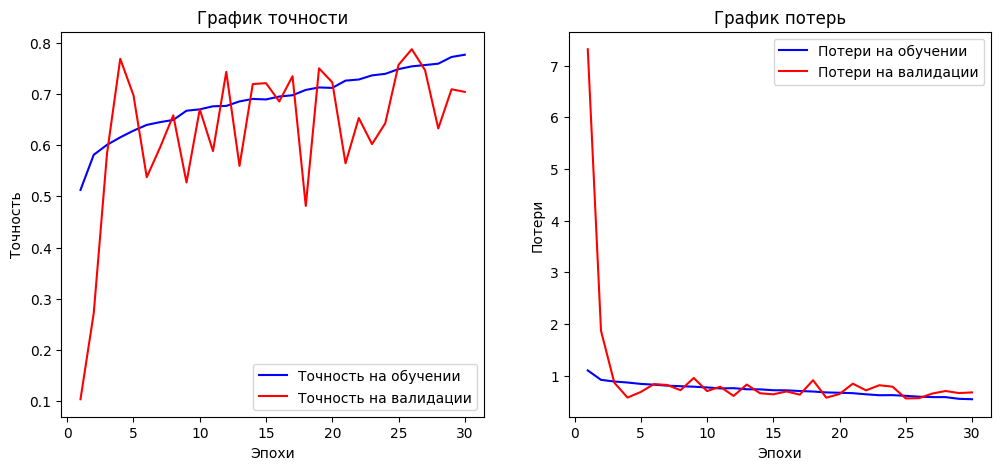

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# –ì—Ä–∞—Ñ–∏–∫ —Ç–æ—á–Ω–æ—Å—Ç–∏
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –æ–±—É—á–µ–Ω–∏–∏")
plt.plot(epochs, val_acc, "r-", label="–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏")
plt.xlabel("–≠–ø–æ—Ö–∏")
plt.ylabel("–¢–æ—á–Ω–æ—Å—Ç—å")
plt.legend()
plt.title("–ì—Ä–∞—Ñ–∏–∫ —Ç–æ—á–Ω–æ—Å—Ç–∏")

# –ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –æ–±—É—á–µ–Ω–∏–∏")
plt.plot(epochs, val_loss, "r-", label="–ü–æ—Ç–µ—Ä–∏ –Ω–∞ –≤–∞–ª–∏–¥–∞—Ü–∏–∏")
plt.xlabel("–≠–ø–æ—Ö–∏")
plt.ylabel("–ü–æ—Ç–µ—Ä–∏")
plt.legend()
plt.title("–ì—Ä–∞—Ñ–∏–∫ –ø–æ—Ç–µ—Ä—å")

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ: {test_acc * 100:.2f}%")

19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 149ms/step - accuracy: 0.7270 - loss: 0.5763
–¢–æ—á–Ω–æ—Å—Ç—å –Ω–∞ —Ç–µ—Å—Ç–µ: 73.42%


In [ ]:

predictions = model.predict(test_generator)


predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

filenames = test_generator.filenames

df = pd.DataFrame({
    "Filename": filenames,
    "True Class": true_classes,
    "Predicted Class": predicted_classes
})

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –≤ CSV
df.to_csv("/content/drive/MyDrive/capillaroscopy/capillaries_classifier2.csv", index=False)
print("–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ predictions_with_filenames.csv")

# –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ 10 —Å—Ç—Ä–æ–∫
print(df.head(10))

19/19 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 115ms/step
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ predictions_with_filenames.csv
                                            Filename  True Class  \
0  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
1  /content/drive/MyDrive/capillaroscopy/data/tra...           2   
2  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
3  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
4  /content/drive/MyDrive/capillaroscopy/data/tra...           2   
5  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
6  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
7  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
8  /content/drive/MyDrive/capillaroscopy/data/tra...           1   
9  /content/drive/MyDrive/capillaroscopy/data/tra...           1   

   Predicted Class  
0                1  
1                2  
2                2  
3       

In [ ]:
model.save("/content/drive/MyDrive/capillaroscopy/capillaries_classifier4.keras")

In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/capillaroscopy/csv/labels.csv")
test_class_0_df = test_df[test_df["class"] == 1].copy()

# –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–ª–Ω—ã–π –ø—É—Ç—å –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è–º
test_class_0_df["filepath"] = test_class_0_df["filename"].apply(lambda x: os.path.join("/content/drive/MyDrive/capillaroscopy/data/train/", x))

print(f"–ù–∞–π–¥–µ–Ω–æ {len(test_class_0_df)} –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∫–ª–∞—Å—Å–∞ 0")

–ù–∞–π–¥–µ–Ω–æ 3354 –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π –∫–ª–∞—Å—Å–∞ 0


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

# –ì–µ–Ω–µ—Ä–∞—Ç–æ—Ä —Ç–æ–ª—å–∫–æ –¥–ª—è –∫–ª–∞—Å—Å–∞ 0
test_class_0_generator = test_datagen.flow_from_dataframe(
    test_class_0_df, x_col="filepath", y_col=None, target_size=(64, 64),
    batch_size=32, class_mode=None, shuffle=False
)

Found 3351 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
predictions = model.predict(test_class_0_generator)

# –ë–µ—Ä–µ–º –∫–ª–∞—Å—Å —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é
predicted_classes = np.argmax(predictions, axis=1)

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
for filename, pred in zip(test_class_0_df["filename"], predicted_classes):
    print(f"{filename}: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å {pred}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 104ms/step
segment_1.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_2.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 2
segment_3.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_4.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 2
segment_5.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_7.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_8.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_9.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_10.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_11.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 0
segment_12.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_13.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_15.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_16.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 2
segment_17.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_18.png: –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å 1
segment_19.png: –ø—Ä–µ–¥—Å–∫

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

–î–µ–ª–∏–º –≤—Ö–æ–¥–Ω–æ–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –Ω–∞ —á–∞—Å—Ç–∏ 64–•64

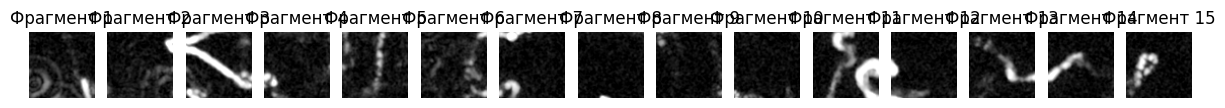

In [ ]:
image_path = "/content/drive/MyDrive/inp/image_capillar (15).png"  # –£–∫–∞–∂–∏ —Å–≤–æ–π –ø—É—Ç—å
image = cv2.imread(image_path)

# –ü—Ä–æ–≤–µ—Ä—è–µ–º –∑–∞–≥—Ä—É–∑–∫—É
if image is None:
    raise ValueError("–û—à–∏–±–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è!")

# –†–∞–∑–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
h, w, _ = image.shape
grid_size = 15  # 15x15 = 225 —á–∞—Å—Ç–µ–π

# –í—ã—á–∏—Å–ª—è–µ–º —Ä–∞–∑–º–µ—Ä—ã –∫–∞–∂–¥–æ–≥–æ –±–ª–æ–∫–∞
tile_h = h // grid_size
tile_w = w // grid_size

# –°–æ–∑–¥–∞–µ–º –ø–∞–ø–∫—É –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
output_folder = "output_tiles"
os.makedirs(output_folder, exist_ok=True)

# –†–∞–∑–±–∏–≤–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –∏ —Å–æ—Ö—Ä–∞–Ω—è–µ–º —Ñ—Ä–∞–≥–º–µ–Ω—Ç—ã
tile_counter = 0
tiles = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è –ø–µ—Ä–≤—ã—Ö 5 —Ñ—Ä–∞–≥–º–µ–Ω—Ç–æ–≤

for i in range(grid_size):
    for j in range(grid_size):
        # –í—ã—á–∏—Å–ª—è–µ–º –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç—ã —Ç–µ–∫—É—â–µ–≥–æ —Ñ—Ä–∞–≥–º–µ–Ω—Ç–∞
        x_start = j * tile_w
        y_start = i * tile_h
        x_end = x_start + tile_w
        y_end = y_start + tile_h

        # –í—ã—Ä–µ–∑–∞–µ–º —Ñ—Ä–∞–≥–º–µ–Ω—Ç
        tile = image[y_start:y_end, x_start:x_end]

        # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ñ—Ä–∞–≥–º–µ–Ω—Ç
        tile_filename = os.path.join(output_folder, f"tile_{tile_counter:03d}.png")
        cv2.imwrite(tile_filename, tile)

        # –î–æ–±–∞–≤–ª—è–µ–º –ø–µ—Ä–≤—ã–µ 5 —Ñ—Ä–∞–≥–º–µ–Ω—Ç–æ–≤ –≤ —Å–ø–∏—Å–æ–∫
        if tile_counter < 15:
            tiles.append(cv2.cvtColor(tile, cv2.COLOR_BGR2RGB))  # –ö–æ–Ω–≤–µ—Ä—Ç–∏—Ä—É–µ–º BGR ‚Üí RGB –¥–ª—è –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è

        tile_counter += 1

fig, axes = plt.subplots(1, 15, figsize=(15, 15))
for idx, ax in enumerate(axes):
    ax.imshow(tiles[idx])
    ax.axis("off")
    ax.set_title(f"–§—Ä–∞–≥–º–µ–Ω—Ç {idx+1}")

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# –ó–∞–≥—Ä—É–∂–∞–µ–º –æ–±—É—á–µ–Ω–Ω—É—é –º–æ–¥–µ–ª—å
model = load_model("/content/drive/MyDrive/capillaroscopy/capillaries_classifier2_func.keras")
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                      ‚îÇ (None, 62, 62, 32)          ‚îÇ             896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization                  ‚îÇ (None, 62, 62, 32)          ‚îÇ             128 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)         ‚îÇ (None, 31, 31, 32)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)                    ‚îÇ (None, 29, 29, 64)          ‚îÇ          18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1                ‚îÇ (None, 29, 29, 64)          ‚îÇ             256 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)       ‚îÇ (None, 14, 14, 64)          ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)                    ‚îÇ (None, 12, 12, 128)         ‚îÇ          73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2                ‚îÇ (None, 12, 12, 128)         ‚îÇ             512 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)       ‚îÇ (None, 6, 6, 128)           ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 1,588,043 (6.06 MB)

 Trainable params: 529,027 (2.02 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,058,056 (4.04 MB)

In [ ]:
# –ü–∞–ø–∫–∞ —Å —Ä–∞–∑—Ä–µ–∑–∞–Ω–Ω—ã–º–∏ —Ñ—Ä–∞–≥–º–µ–Ω—Ç–∞–º–∏
tile_folder = "output_tiles"
tile_size = (64, 64)  # –†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π, –∫–æ—Ç–æ—Ä—ã–π –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª–∞ –º–æ–¥–µ–ª—å

# –ó–∞–≥—Ä—É–∂–∞–µ–º –≤—Å–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∏–∑ –ø–∞–ø–∫–∏
image_files = sorted(os.listdir(tile_folder))  # –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∏–º–µ–Ω–∏
tiles = []

for filename in image_files:
    img_path = os.path.join(tile_folder, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue  # –ü—Ä–æ–ø—É—Å–∫–∞–µ–º, –µ—Å–ª–∏ —Ñ–∞–π–ª –Ω–µ –∑–∞–≥—Ä—É–∑–∏–ª—Å—è

    # –ò–∑–º–µ–Ω—è–µ–º —Ä–∞–∑–º–µ—Ä –ø–æ–¥ –≤—Ö–æ–¥–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏
    img = cv2.resize(img, tile_size)

    # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –∑–Ω–∞—á–µ–Ω–∏–π –ø–∏–∫—Å–µ–ª–µ–π
    img = img / 255.0

    # –î–æ–±–∞–≤–ª—è–µ–º –≤ —Å–ø–∏—Å–æ–∫
    tiles.append(img)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ numpy-–º–∞—Å—Å–∏–≤ –¥–ª—è –ø–æ–¥–∞—á–∏ –≤ –º–æ–¥–µ–ª—å
tiles = np.array(tiles)

In [ ]:
# –î–µ–ª–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
predictions = model.predict(tiles)

# –ü–æ–ª—É—á–∞–µ–º –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–π –∫–ª–∞—Å—Å –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ñ—Ä–∞–≥–º–µ–Ω—Ç–∞
predicted_classes = np.argmax(predictions, axis=1)

# –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ 10 –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π
for i in range(10):
    print(f"üìå –§–∞–π–ª: {image_files[i]} ‚Üí –ö–ª–∞—Å—Å: {predicted_classes[i]}")

8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 158ms/step
üìå –§–∞–π–ª: tile_000.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_001.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_002.png ‚Üí –ö–ª–∞—Å—Å: 0
üìå –§–∞–π–ª: tile_003.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_004.png ‚Üí –ö–ª–∞—Å—Å: 1
üìå –§–∞–π–ª: tile_005.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_006.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_007.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_008.png ‚Üí –ö–ª–∞—Å—Å: 2
üìå –§–∞–π–ª: tile_009.png ‚Üí –ö–ª–∞—Å—Å: 2


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Filename": image_files,
    "Predicted Class": predicted_classes
})

df.to_csv("/content/drive/MyDrive/capillaroscopy/tile_predictions.csv", index=False)
print("üìÅ –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ tile_predictions.csv")

üìÅ –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ tile_predictions.csv


8/8 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 16ms/step


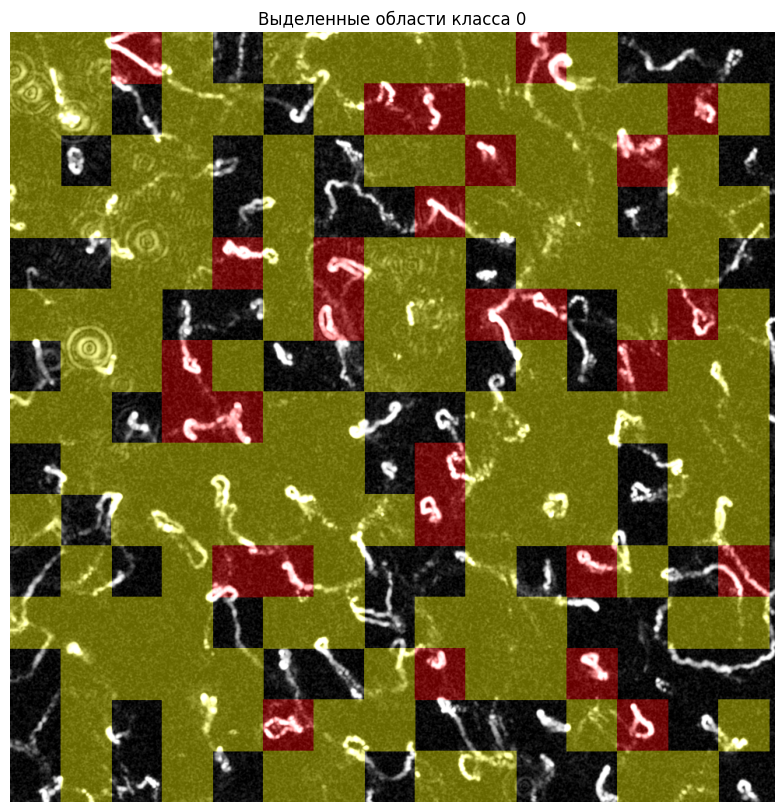

In [ ]:
original_image = cv2.imread(image_path)

if original_image is None:
    raise ValueError("–û—à–∏–±–∫–∞ –∑–∞–≥—Ä—É–∑–∫–∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è!")

h, w, _ = original_image.shape  # –†–∞–∑–º–µ—Ä –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è

# üîπ –ü–∞–ø–∫–∞ —Å —Ä–∞–∑—Ä–µ–∑–∞–Ω–Ω—ã–º–∏ —á–∞—Å—Ç—è–º–∏
tile_folder = "output_tiles"
tile_size = (64, 64)  # –†–∞–∑–º–µ—Ä, –Ω–∞ –∫–æ—Ç–æ—Ä—ã–π –Ω–∞—Ç—Ä–µ–Ω–∏—Ä–æ–≤–∞–Ω–∞ –º–æ–¥–µ–ª—å
grid_size = 15 # –†–∞–∑–±–∏–µ–Ω–∏–µ 15x15 = 225 —á–∞—Å—Ç–µ–π

# –ó–∞–≥—Ä—É–∂–∞–µ–º –≤—Å–µ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è
image_files = sorted(os.listdir(tile_folder))
tiles = []

for filename in image_files:
    img_path = os.path.join(tile_folder, filename)
    img = cv2.imread(img_path)

    if img is None:
        continue

    # –ò–∑–º–µ–Ω—è–µ–º —Ä–∞–∑–º–µ—Ä –ø–æ–¥ –≤—Ö–æ–¥ –º–æ–¥–µ–ª–∏
    img = cv2.resize(img, tile_size)
    img = img / 255.0  # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
    tiles.append(img)

# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –≤ numpy-–º–∞—Å—Å–∏–≤
tiles = np.array(tiles)

# üîπ –ü—Ä–æ–≥–æ–Ω—è–µ–º —á–µ—Ä–µ–∑ –º–æ–¥–µ–ª—å
predictions = model.predict(tiles)
predicted_classes = np.argmax(predictions, axis=1)  # –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∫–ª–∞—Å—Å—ã

# üîπ –í–æ—Å—Å—Ç–∞–Ω–∞–≤–ª–∏–≤–∞–µ–º —Ä–∞–∑–±–∏–µ–Ω–∏–µ –ø–æ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—é
tile_h = h // grid_size
tile_w = w // grid_size

# üî• –°–æ–∑–¥–∞–µ–º –º–∞—Å–∫—É –¥–ª—è –≤—ã–¥–µ–ª–µ–Ω–∏—è –æ–±–ª–∞—Å—Ç–µ–π –∫–ª–∞—Å—Å–∞ 0
mask = np.zeros_like(original_image, dtype=np.uint8)

tile_counter = 0
for i in range(grid_size):
    for j in range(grid_size):
        x_start, y_start = j * tile_w, i * tile_h
        x_end, y_end = x_start + tile_w, y_start + tile_h

        if predicted_classes[tile_counter] == 0:  # –ï—Å–ª–∏ –∫–ª–∞—Å—Å 0, —Ä–∏—Å—É–µ–º –∫—Ä–∞—Å–Ω—É—é –º–∞—Å–∫—É
            cv2.rectangle(mask, (x_start, y_start), (x_end, y_end), (0, 0, 255), -1)  # –ö—Ä–∞—Å–Ω—ã–π
        elif predicted_classes[tile_counter] == 2:
             cv2.rectangle(mask, (x_start, y_start), (x_end, y_end), (0, 255, 255), -1)

        tile_counter += 1

# üîπ –î–æ–±–∞–≤–ª—è–µ–º –º–∞—Å–∫—É –∫ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—é
alpha = 0.4  # –ü—Ä–æ–∑—Ä–∞—á–Ω–æ—Å—Ç—å
highlighted_image = cv2.addWeighted(original_image, 1, mask, alpha, 0)

# üìå –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("–í—ã–¥–µ–ª–µ–Ω–Ω—ã–µ –æ–±–ª–∞—Å—Ç–∏ –∫–ª–∞—Å—Å–∞ 0")
plt.show()

In [ ]:
import pandas as pd

# –ß–∏—Ç–∞–µ–º –∏—Å—Ö–æ–¥–Ω—ã–π —Ñ–∞–π–ª CSV
df = pd.read_csv("/content/drive/MyDrive/capillaroscopy/csv/labels.csv")

# –ó–∞–º–µ–Ω—è–µ–º –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è 2 –≤ —Å—Ç–æ–ª–±—Ü–µ "class" –Ω–∞ 0
df.loc[df["class"] == 2, "class"] = 1

# –°–æ—Ö—Ä–∞–Ω—è–µ–º –∏–∑–º–µ–Ω–µ–Ω–∏—è –≤ –∏—Å—Ö–æ–¥–Ω—ã–π CSV (–º–æ–∂–Ω–æ —É–∫–∞–∑–∞—Ç—å –Ω–æ–≤—ã–π —Ñ–∞–π–ª)
df.to_csv("/content/drive/MyDrive/capillaroscopy/csv/labels_three.csv", index=False)